In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Inner tank dimensions
height   = 700e-3 # m
diameter = 150e-3 # m (inner)
area = math.pi * diameter**2 / 4

tankMass = 5 # kg (CG of tank will be assumed in the center of tank)

densityLiquid = 1141  # kg/m^3
densityGas    = 1.309 # kg/m^3

massFlowRate = 2 # kg/s

startLiquidHeight = 600e-3 # m (from bottom of tank as if it's upright and gravity is acting normally)

Find CG by treating the tank as three point masses (tank, liquid, gas) and then the CG is the weighted average following:
$$\text{CG}=\frac{\sum m_ix_i}{\sum m_i}.$$


In [3]:
def cg_height(liquidHeight):
    area = math.pi * diameter**2 / 4
    liquidMass = area * liquidHeight * densityLiquid
    gasMass = area * (height-liquidHeight) * densityGas
    totalMass = liquidMass + gasMass + tankMass

    center = height/2
    liquidCenter = liquidHeight/2
    gasCenter = (height + liquidHeight)/2

    cg = (tankMass*center + gasMass*gasCenter + liquidMass*liquidCenter)/totalMass
    
    return cg, totalMass

def simulate_cg_curve(timeLength=4, step=10e-3):
    t = np.arange(0, timeLength+step, step)

    liquidHeight = startLiquidHeight - t*massFlowRate/densityLiquid/area
    liquidHeight[liquidHeight < 0] = 0

    cg, mass = cg_height(liquidHeight)
    return t, cg, mass

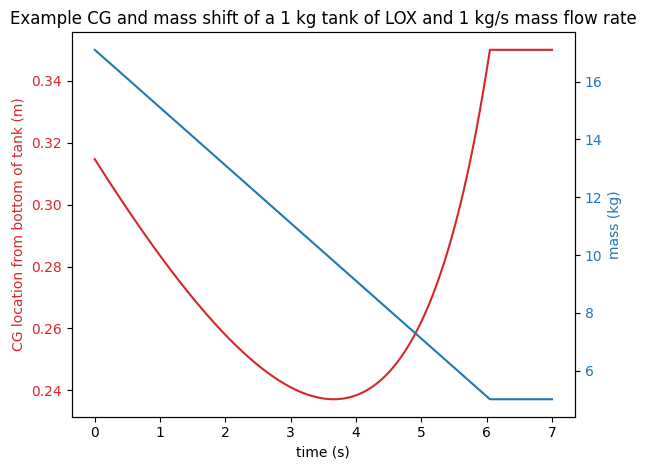

In [4]:
t, cg, mass = simulate_cg_curve(7)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('CG location from bottom of tank (m)', color=color)
ax1.plot(t, cg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('mass (kg)', color=color)
ax2.plot(t, mass, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Example CG and mass shift of a 1 kg tank of LOX and 1 kg/s mass flow rate')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [8]:
# Convert coordinates to be 0 from the leading edge of motor
convertedCG = height - cg

string = f'''<engine-database>
  <engine-list>
    <engine Type="Tank"
    auto-calc-cg="0"
    auto-calc-mass="0"
    code="LOXTank"
    delays="0"
    dia="{diameter*1000}"
    len="{height*1000}"
    initWt="{mass[0]*1000}"
    propWt="{(mass[0]-tankMass)*1000}"
    mfg="VOID">
      <data>\n'''

for i in range(len(t)):
    string += f'        <eng-data cg="{convertedCG[i]}" f="0." m="{mass[i]}" t="{t[i]}"/>\n'

string += '''      </data>
    </engine>
  </engine-list>
</engine-database>
'''


In [7]:
with open("Output/output.rse", "w") as file:
        file.write(string)